In [19]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

ni_nodes = 5
nj_nodes = 5
xmin = -5
xmax = 5
ymin = -5
ymax = 5

def make_uniform_grid(n_nodes=(1,1), xrange=(0,1), yrange=(0,1)):
    """Create an empty grid"""
    ghost_cell = 1
        
    x = np.linspace(xrange[0],xrange[1],n_nodes[0])
    ldx = x[1] - x[0]
    rdx = x[-1] - x[-2]
    x = np.array([x[0]-ldx] + list(x) + [x[-1]+rdx])
    
    y = np.linspace(yrange[0],yrange[1],n_nodes[1])
    ldy = y[1] - y[0]
    rdy = y[-1] - y[-2]
    y = np.array([y[0]-ldy] + list(y) + [y[-1]+rdy])

    xc = np.zeros(x.shape[0] - 1)
    yc = np.zeros(y.shape[0] - 1)

    xx, yy = np.meshgrid(x, y)
    xxc, yyc = np.meshgrid(xc, yc)

    rho = np.ones_like(xxc)
    pressure = np.ones_like(xxc)
    u = np.ones_like(xxc)
    v = np.ones_like(xxc)
    
    dy = (np.diff(yy[:,0])/2)[0]
    dx = (np.diff(xx[0,:])/2)[0]
    xc = xx[:-1,:-1] + dx
    yc = yy[:-1,:-1] + dy

    return {'x':xx,'y':yy,'rho':rho,'u':u,'v':v,'p':pressure, 'xc':xc, 'yc':yc}


init_cond = make_uniform_grid(n_nodes=(101,101), xrange=(-5,5), yrange=(-5,5))

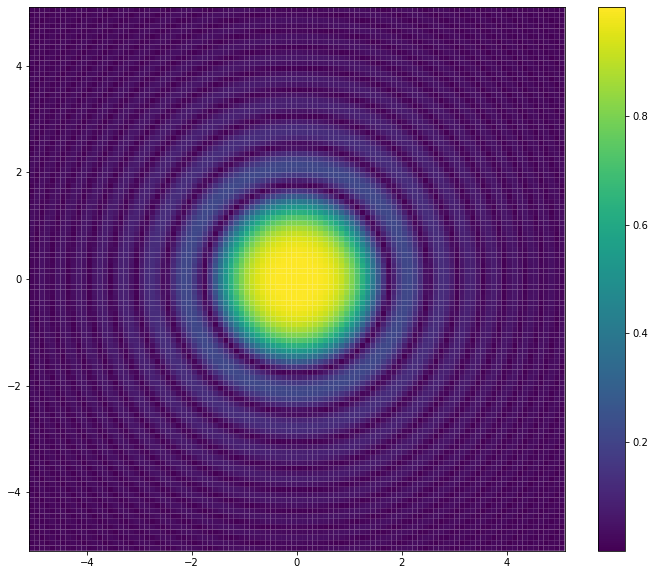

In [20]:
dy = (np.diff(init_cond['y'][:,0]))[0]
dx = (np.diff(init_cond['x'][0,:]))[0]
xc = init_cond['x'][:-1,:-1] + (dx/2.0)
yc = init_cond['y'][:-1,:-1] + (dy/2.0)

rho = np.abs(np.sin((xc ** 2 + yc ** 2)) / (xc ** 2 + yc ** 2))
plt.figure(figsize=(12,10))
plt.pcolormesh(init_cond['x'],init_cond['y'],rho,edgecolor='k', lw=.001, antialiased=True)
plt.colorbar()
plt.show()

## Double Periodic Shear Layer

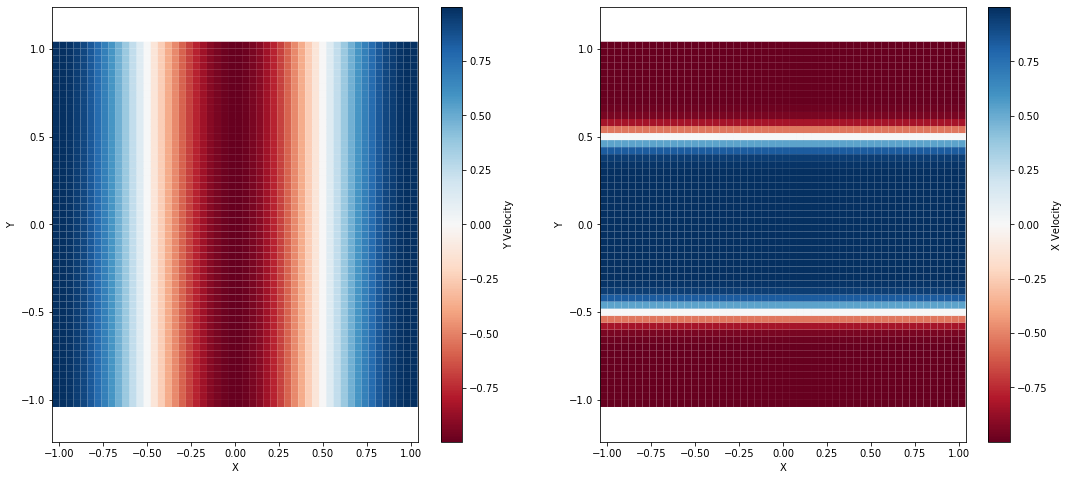

In [21]:
double_shear = make_uniform_grid(n_nodes=(51, 51), xrange=(-1, 1), yrange=(-1, 1))
double_shear['rho'] = double_shear['rho'] * 1.4
double_shear['p'] = double_shear['p'] * 4

x=double_shear['xc']
y=double_shear['yc']

double_shear['v'] = np.sin(np.pi * (x + 1.5))
for i in range(y.shape[0]):
    for j in range(y.shape[1]):
        if y[i,j] < 0:
            double_shear['u'][i,j] = np.tanh(15*(0.5+y[i,j]))
        else:
            double_shear['u'][i,j] = np.tanh(15*(0.5-y[i,j]))
            
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), nrows=1, ncols=2)
vc = ax1.pcolormesh(double_shear['x'],
               double_shear['y'],
               double_shear['v'],
               edgecolor='k',
               lw=.001,
               cmap='RdBu',
               antialiased=True)
fig.colorbar(vc, ax=ax1, label='Y Velocity')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

uc = ax2.pcolormesh(double_shear['x'],
               double_shear['y'],
               double_shear['u'],
               edgecolor='k',
               lw=.001,
               cmap='RdBu',
               antialiased=True)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

fig.colorbar(uc, ax=ax2, label='X Velocity')
ax1.axis('equal')
ax2.axis('equal')
plt.show()

In [25]:
def write_initial_hdf5(filename, initial_condition_dict,
                       boundary_conditions_dict):
    """
    boundary_conditions_dict: Dict
        Needs to have the keys [+x,+y,-x,-y]
    """

    if not filename.endswith('.h5'):
        filename += '.h5'

    print('Writing to: ', filename)
    with h5py.File(filename, mode='w') as h5:
        h5.create_dataset('/x',
                          data=initial_condition_dict['x'].astype(np.float32),
                          compression="gzip",
                          compression_opts=9)
        h5.create_dataset('/y',
                          data=initial_condition_dict['y'].astype(np.float32),
                          compression="gzip",
                          compression_opts=9)
        h5.create_dataset('/density',
                          data=initial_condition_dict['rho'].astype(np.float32),
                          compression="gzip",
                          compression_opts=9)
        h5.create_dataset('/x_velocity',
                          data=initial_condition_dict['u'].astype(np.float32),
                          compression="gzip",
                          compression_opts=9)
        h5.create_dataset('/y_velocity',
                          data=initial_condition_dict['v'].astype(np.float32),
                          compression="gzip",
                          compression_opts=9)
        h5.create_dataset('/pressure',
                          data=initial_condition_dict['p'].astype(np.float32),
                          compression="gzip",
                          compression_opts=9)

        # Boundary Conditions
        h5.create_dataset('/plus_x_bc',data=boundary_conditions_dict['+x'])
        h5.create_dataset('/plus_y_bc',data=boundary_conditions_dict['+y'])
        h5.create_dataset('/minus_x_bc',data=boundary_conditions_dict['-x'])
        h5.create_dataset('/minus_y_bc',data=boundary_conditions_dict['-y'])
        h5.close()


bc_dict = {
    '+x': 'periodic',
    '+y': 'periodic',
    '-x': 'periodic',
    '-y': 'periodic'
}

write_initial_hdf5(filename='double_shear',
                   initial_condition_dict=double_shear,
                   boundary_conditions_dict=bc_dict)


Writing to:  double_shear.h5


In [192]:
double_shear['rho'].astype(np.float32)

array([[1.4, 1.4, 1.4, ..., 1.4, 1.4, 1.4],
       [1.4, 1.4, 1.4, ..., 1.4, 1.4, 1.4],
       [1.4, 1.4, 1.4, ..., 1.4, 1.4, 1.4],
       ...,
       [1.4, 1.4, 1.4, ..., 1.4, 1.4, 1.4],
       [1.4, 1.4, 1.4, ..., 1.4, 1.4, 1.4],
       [1.4, 1.4, 1.4, ..., 1.4, 1.4, 1.4]], dtype=float32)

In [13]:
import numpy as np
import h5py
x = np.linspace(-2, 2, 5, dtype=np.float32)
y = np.linspace(-2, 2, 3, dtype=np.float32)
xx, yy = np.meshgrid(x, y)
with h5py.File('simple.h5', mode='w') as h5:
    h5.create_dataset('/x',data=xx)
    h5.create_dataset('/y',data=yy)
    

In [27]:
bc_dict = {
    '+x': 'periodic',
    '+y': 'periodic',
    '-x': 'periodic',
    '-y': 'periodic'
}
simple = make_uniform_grid(n_nodes=(5,3), xrange=(-2,2), yrange=(-2,2))
simple['rho'] = simple['rho'] * 1
simple['u'] = simple['p'] * -2
simple['v'] = simple['p'] * 3
simple['p'] = simple['p'] * 4
write_initial_hdf5(filename='simple',
                   initial_condition_dict=simple,
                   boundary_conditions_dict=bc_dict)

Writing to:  simple.h5


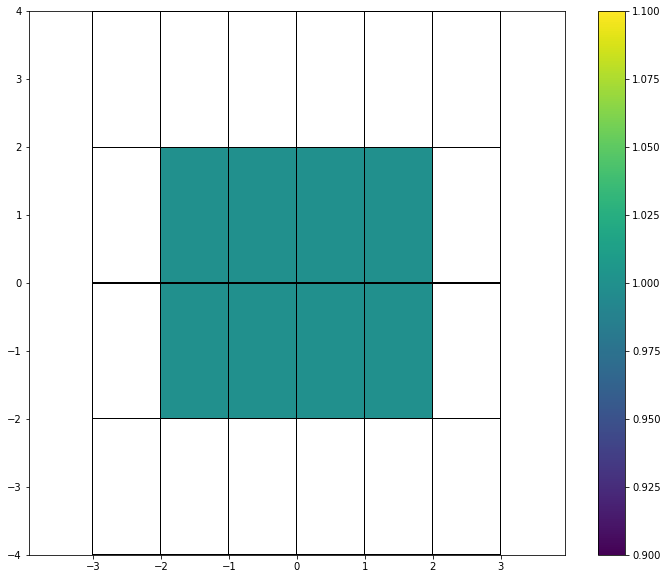

In [37]:
plt.figure(figsize=(12, 10))
simple['rho'][0,:] = np.nan
simple['rho'][:,0] = np.nan
simple['rho'][-1,:] = np.nan
simple['rho'][:,-1] = np.nan
plt.pcolormesh(simple['x'],
               simple['y'],
               simple['rho'],
               edgecolor='k',
               lw=.01,
               antialiased=False)
plt.gca().axis('equal')
plt.colorbar()
plt.show()
